In [512]:
import numpy as np 
import pandas as pd 
import re

col_names= ['JOBID', 'ACCOUNT', 'USER', 'REQMEM', 'USEDMEM', 'REQTIME', 'USEDTIME',
       'NODES', 'CPUS', 'PARTITION', 'EXITCODE', 'STATE', 'NODE1','NODE2','NODE3','NODE4']

accre_df = pd.read_csv('../data/accre-jobs-2020.csv', names=col_names, nrows = 100000) 
accre_df = accre_df.iloc[1:]

In [513]:
accre_df = pd.read_csv('../data/accre-jobs-2020.csv', error_bad_lines=False)

b'Skipping line 3461: expected 13 fields, saw 15\nSkipping line 3462: expected 13 fields, saw 16\nSkipping line 3465: expected 13 fields, saw 15\nSkipping line 3468: expected 13 fields, saw 16\nSkipping line 3472: expected 13 fields, saw 15\nSkipping line 3476: expected 13 fields, saw 16\nSkipping line 3479: expected 13 fields, saw 14\nSkipping line 3482: expected 13 fields, saw 14\nSkipping line 3486: expected 13 fields, saw 14\nSkipping line 3490: expected 13 fields, saw 14\nSkipping line 3494: expected 13 fields, saw 14\nSkipping line 3495: expected 13 fields, saw 16\nSkipping line 3497: expected 13 fields, saw 14\nSkipping line 3498: expected 13 fields, saw 14\nSkipping line 3499: expected 13 fields, saw 14\nSkipping line 3505: expected 13 fields, saw 14\nSkipping line 3517: expected 13 fields, saw 16\nSkipping line 3526: expected 13 fields, saw 15\nSkipping line 3528: expected 13 fields, saw 15\nSkipping line 3529: expected 13 fields, saw 15\nSkipping line 3530: expected 13 fields

b'Skipping line 268649: expected 13 fields, saw 16\nSkipping line 281380: expected 13 fields, saw 14\nSkipping line 283158: expected 13 fields, saw 48\nSkipping line 289776: expected 13 fields, saw 70\nSkipping line 290568: expected 13 fields, saw 15\nSkipping line 317525: expected 13 fields, saw 14\n'
b'Skipping line 329958: expected 13 fields, saw 14\nSkipping line 330461: expected 13 fields, saw 14\nSkipping line 332666: expected 13 fields, saw 15\nSkipping line 332762: expected 13 fields, saw 14\nSkipping line 332764: expected 13 fields, saw 14\nSkipping line 332766: expected 13 fields, saw 14\nSkipping line 332768: expected 13 fields, saw 14\nSkipping line 332769: expected 13 fields, saw 16\nSkipping line 332770: expected 13 fields, saw 14\nSkipping line 332898: expected 13 fields, saw 16\nSkipping line 332899: expected 13 fields, saw 14\nSkipping line 332900: expected 13 fields, saw 16\nSkipping line 332901: expected 13 fields, saw 14\nSkipping line 332902: expected 13 fields, sa

b'Skipping line 531726: expected 13 fields, saw 14\nSkipping line 543870: expected 13 fields, saw 14\nSkipping line 543903: expected 13 fields, saw 14\nSkipping line 544434: expected 13 fields, saw 14\nSkipping line 545969: expected 13 fields, saw 14\nSkipping line 546305: expected 13 fields, saw 43\nSkipping line 547218: expected 13 fields, saw 15\nSkipping line 547223: expected 13 fields, saw 56\nSkipping line 547224: expected 13 fields, saw 20\nSkipping line 547225: expected 13 fields, saw 22\nSkipping line 547226: expected 13 fields, saw 20\nSkipping line 547228: expected 13 fields, saw 19\nSkipping line 547230: expected 13 fields, saw 23\nSkipping line 547231: expected 13 fields, saw 25\nSkipping line 547233: expected 13 fields, saw 33\nSkipping line 547234: expected 13 fields, saw 53\nSkipping line 547245: expected 13 fields, saw 20\nSkipping line 547353: expected 13 fields, saw 14\nSkipping line 547359: expected 13 fields, saw 19\nSkipping line 547360: expected 13 fields, saw 21

b'Skipping line 660901: expected 13 fields, saw 15\nSkipping line 661332: expected 13 fields, saw 15\nSkipping line 662656: expected 13 fields, saw 14\nSkipping line 662863: expected 13 fields, saw 51\nSkipping line 662901: expected 13 fields, saw 15\nSkipping line 662902: expected 13 fields, saw 14\nSkipping line 662903: expected 13 fields, saw 14\nSkipping line 662904: expected 13 fields, saw 14\nSkipping line 662905: expected 13 fields, saw 14\nSkipping line 662906: expected 13 fields, saw 14\nSkipping line 662910: expected 13 fields, saw 14\nSkipping line 662914: expected 13 fields, saw 14\nSkipping line 662915: expected 13 fields, saw 15\nSkipping line 662916: expected 13 fields, saw 15\nSkipping line 662917: expected 13 fields, saw 15\nSkipping line 662918: expected 13 fields, saw 15\nSkipping line 662921: expected 13 fields, saw 15\nSkipping line 662922: expected 13 fields, saw 16\nSkipping line 662923: expected 13 fields, saw 19\nSkipping line 662924: expected 13 fields, saw 19

b'Skipping line 791715: expected 13 fields, saw 14\nSkipping line 791716: expected 13 fields, saw 14\nSkipping line 791946: expected 13 fields, saw 14\nSkipping line 802071: expected 13 fields, saw 36\nSkipping line 803524: expected 13 fields, saw 14\nSkipping line 803526: expected 13 fields, saw 16\nSkipping line 803532: expected 13 fields, saw 14\nSkipping line 805310: expected 13 fields, saw 14\nSkipping line 807766: expected 13 fields, saw 16\nSkipping line 807886: expected 13 fields, saw 14\nSkipping line 807912: expected 13 fields, saw 14\nSkipping line 807915: expected 13 fields, saw 16\nSkipping line 809885: expected 13 fields, saw 16\nSkipping line 810653: expected 13 fields, saw 15\nSkipping line 819442: expected 13 fields, saw 14\nSkipping line 820633: expected 13 fields, saw 15\nSkipping line 821828: expected 13 fields, saw 17\nSkipping line 821846: expected 13 fields, saw 24\nSkipping line 821852: expected 13 fields, saw 20\nSkipping line 821853: expected 13 fields, saw 20

b'Skipping line 1386352: expected 14 fields, saw 31\nSkipping line 1410576: expected 14 fields, saw 20\nSkipping line 1410942: expected 14 fields, saw 19\nSkipping line 1419277: expected 14 fields, saw 18\nSkipping line 1421945: expected 14 fields, saw 16\nSkipping line 1422429: expected 14 fields, saw 16\nSkipping line 1422430: expected 14 fields, saw 16\nSkipping line 1422431: expected 14 fields, saw 16\nSkipping line 1422432: expected 14 fields, saw 16\nSkipping line 1422433: expected 14 fields, saw 15\nSkipping line 1422434: expected 14 fields, saw 15\nSkipping line 1422435: expected 14 fields, saw 15\nSkipping line 1422436: expected 14 fields, saw 15\nSkipping line 1422437: expected 14 fields, saw 16\nSkipping line 1422439: expected 14 fields, saw 15\nSkipping line 1422542: expected 14 fields, saw 16\nSkipping line 1425142: expected 14 fields, saw 31\nSkipping line 1425366: expected 14 fields, saw 34\nSkipping line 1425553: expected 14 fields, saw 29\nSkipping line 1426269: expect

b'Skipping line 2205329: expected 14 fields, saw 15\nSkipping line 2205360: expected 14 fields, saw 18\nSkipping line 2205364: expected 14 fields, saw 16\nSkipping line 2205371: expected 14 fields, saw 15\nSkipping line 2205376: expected 14 fields, saw 16\nSkipping line 2205381: expected 14 fields, saw 15\nSkipping line 2205410: expected 14 fields, saw 15\nSkipping line 2205411: expected 14 fields, saw 17\nSkipping line 2205415: expected 14 fields, saw 17\nSkipping line 2205418: expected 14 fields, saw 17\nSkipping line 2205422: expected 14 fields, saw 17\nSkipping line 2205430: expected 14 fields, saw 16\nSkipping line 2205432: expected 14 fields, saw 17\nSkipping line 2205435: expected 14 fields, saw 16\nSkipping line 2205436: expected 14 fields, saw 19\nSkipping line 2205438: expected 14 fields, saw 17\nSkipping line 2205440: expected 14 fields, saw 17\nSkipping line 2205444: expected 14 fields, saw 19\nSkipping line 2205445: expected 14 fields, saw 16\nSkipping line 2205446: expect

b'Skipping line 2315585: expected 14 fields, saw 15\nSkipping line 2315586: expected 14 fields, saw 16\nSkipping line 2315590: expected 14 fields, saw 15\nSkipping line 2320415: expected 14 fields, saw 17\nSkipping line 2320416: expected 14 fields, saw 16\nSkipping line 2320417: expected 14 fields, saw 16\nSkipping line 2320418: expected 14 fields, saw 17\nSkipping line 2320419: expected 14 fields, saw 17\nSkipping line 2320420: expected 14 fields, saw 16\nSkipping line 2320421: expected 14 fields, saw 16\nSkipping line 2320422: expected 14 fields, saw 16\nSkipping line 2320423: expected 14 fields, saw 15\nSkipping line 2320424: expected 14 fields, saw 17\nSkipping line 2320425: expected 14 fields, saw 17\nSkipping line 2320426: expected 14 fields, saw 15\nSkipping line 2320427: expected 14 fields, saw 15\nSkipping line 2320428: expected 14 fields, saw 17\nSkipping line 2320429: expected 14 fields, saw 17\nSkipping line 2320430: expected 14 fields, saw 17\nSkipping line 2320431: expect

b'Skipping line 2847140: expected 14 fields, saw 15\nSkipping line 2860040: expected 14 fields, saw 17\nSkipping line 2860041: expected 14 fields, saw 17\nSkipping line 2860042: expected 14 fields, saw 17\nSkipping line 2860043: expected 14 fields, saw 15\nSkipping line 2860502: expected 14 fields, saw 55\nSkipping line 2861007: expected 14 fields, saw 17\nSkipping line 2861008: expected 14 fields, saw 17\nSkipping line 2861009: expected 14 fields, saw 17\nSkipping line 2861010: expected 14 fields, saw 17\nSkipping line 2861011: expected 14 fields, saw 17\nSkipping line 2861012: expected 14 fields, saw 17\nSkipping line 2861013: expected 14 fields, saw 17\nSkipping line 2861014: expected 14 fields, saw 17\nSkipping line 2861015: expected 14 fields, saw 17\nSkipping line 2861016: expected 14 fields, saw 17\nSkipping line 2863495: expected 14 fields, saw 25\nSkipping line 2868077: expected 14 fields, saw 17\nSkipping line 2868078: expected 14 fields, saw 17\nSkipping line 2868079: expect

In [514]:
#subsetting data for cms
cms_df = accre_df[accre_df['ACCOUNT']=='cms']
cms_df = cms_df[cms_df['PARTITION']!='debug']
cms_df = cms_df[(cms_df['USER']=='cmspilot')|(cms_df['USER']=='cmslocal')]

In [515]:
#Subset for used time less than an hour

The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot".

For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes.

Do any of their jobs that ended in under an hour also cluster on specific compute nodes, 
suggesting possbily unreliable systems? 

Check both “production” and “nogpfs” partitions. 

Look for commonly failing nodes and compare with other failed jobs.

In [516]:
cms_df.shape

(699831, 13)

In [517]:
#getting time under an hour
cms_df['under_hour'] = False

for index, row in cms_df.USEDTIME.iteritems():
    chopped_row = row.split(":")
    if chopped_row[0] == '00':
        cms_df['under_hour'][index] = True

C:\Users\savro\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [525]:
cms_df = cms_df[cms_df['under_hour'] == True]

pd.set_option('display.max_rows', 500)
cms_df

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,under_hour
8318,17094524,cms,cmslocal,186648Mn,0,2-00:00:00,00:30:35,1,32,nogpfs,0:0,CANCELLED,cn1556,True
8320,17094527,cms,cmslocal,186648Mn,0,2-00:00:00,00:30:35,1,32,nogpfs,0:0,CANCELLED,cn1580,True
8340,17094547,cms,cmslocal,186648Mn,0,2-00:00:00,00:16:16,1,32,nogpfs,0:0,CANCELLED,cn1559,True
8341,17094548,cms,cmslocal,186648Mn,0,2-00:00:00,00:16:16,1,32,nogpfs,0:0,CANCELLED,cn1573,True
8342,17094549,cms,cmslocal,186648Mn,0,2-00:00:00,00:16:16,1,32,nogpfs,0:0,CANCELLED,cn1574,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813280,24173153,cms,cmspilot,28000Mn,0,2-00:00:00,00:06:41,1,4,production,0:0,RUNNING,cn1513,True
3813281,24173154,cms,cmspilot,28000Mn,0,2-00:00:00,00:06:41,1,4,production,0:0,RUNNING,cn461,True
3813282,24173155,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1516,True
3813283,24173156,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1524,True


In [523]:
#getting only failed jobs
cms_df = cms_df[cms_df['STATE'] != 'COMPLETED']
cms_df['STATE'].value_counts()

CANCELLED            1597
RUNNING                70
FAILED                 60
CANCELLED by 9202       3
CANCELLED by 9201       3
Name: STATE, dtype: int64

In [520]:
cms_df['NODELIST'].value_counts().head(20)

ng518     16
cn1314    12
cn394     11
ng734     10
cn1094     9
cn475      9
ng1112     9
cn1121     9
cn304      9
cn449      9
cn399      8
cn363      8
cn1398     8
cn1394     8
cn1387     8
cn408      8
cn312      8
cn429      8
cn1391     7
cn485      7
Name: NODELIST, dtype: int64

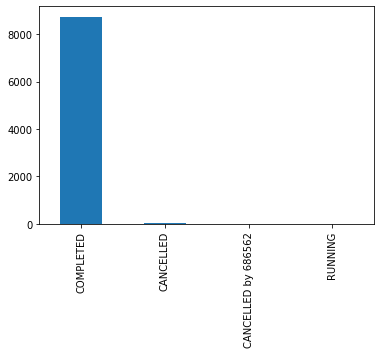

In [521]:
testing_cn1314 = accre_df[accre_df['NODELIST'] == 'cn1314']
testing_cn1314['STATE'].value_counts().plot(kind = 'bar')

In [ ]:
accre_df['NODES'] = accre_df['NODES'].astype(int)

In [ ]:
accre_df['CPUS'] = accre_df['CPUS'].astype(int)

In [ ]:
accre_df.dtypes

In [ ]:
exactly_2_nodes = accre_df[accre_df['NODES'] == 2]
exactly_2_nodes.shape

In [ ]:
# concatinating all nodes into the NODE1 column
for index, row in accre_df.NODE1.iteritems():
    node1 = str(accre_df['NODE1'][index])
    node2 = str(accre_df['NODE2'][index])
    node3 = str(accre_df['NODE3'][index])
    node4 = str(accre_df['NODE4'][index])
    
    accre_df['NODE2'][index] = ''
    accre_df['NODE3'][index] = ''
    accre_df['NODE4'][index] = ''
    
    node_row = node1 + ',' + node2 + ',' + node3 + ',' + node4
    node_row = node_row.split('nan')[0]
    accre_df['NODE1'][index] = node_row[:-1]
    
#dropping columns NODE2-NODE4
accre_df = accre_df.drop(['NODE2', 'NODE3', 'NODE4'], axis=1)

for index, row in accre_df.NODE1.iteritems():
    if accre_df['NODE4'][index] == accre_df['NODE4'][index]:
        node1 = accre_df['NODE1'][index] + ',' + str(accre_df['NODE2'][index]) + ',' + str(accre_df['NODE3'][index]) + ',' + str(accre_df['NODE4'][index])
    elif accre_df['NODE3'][index] == accre_df['NODE3'][index]:
        node1 = accre_df['NODE1'][index] + ',' + str(accre_df['NODE2'][index]) + ',' + str(accre_df['NODE3'][index])
    elif accre_df['NODE2'][index] == accre_df['NODE2'][index]:
        node1 = accre_df['NODE1'][index] + ',' + str(accre_df['NODE2'][index])
    else:
        node1 = accre_df['NODE1'][index]
    accre_df['NODE1'][index] = node1

#This fixes formatting for when NODES = 2, press 'esc'-'o' to hide pink warning
for index, row in accre_df.NODE1.iteritems():
    if accre_df.NODES[index] == 2:
        broken_node1 = row.split('[')

        if len(broken_node1[1]) < 5:
            accre_df['NODE1'][index] = broken_node1[0] + broken_node1[1]
            accre_df['NODE2'][index] = broken_node1[0] + accre_df['NODE2'][index][:-1]
            
        else:
            broken_node1[1] = broken_node1[1][:-1]
            two_num_split = broken_node1[1].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE2'][index] = broken_node1[0] + two_num_split[1]            

In [ ]:
accre_df.head()

In [ ]:
accre_df[accre_df['NODES'] == 2]

#This fixes formatting for when NODES = 3, press 'esc'-'o' to hide pink warning
for index, row in accre_df.NODE1.iteritems():          
    if accre_df.NODES[index] == 3:
        
        broken_node1 = row.split('[')

        if accre_df['NODE3'][index] == accre_df['NODE3'][index]:
            accre_df['NODE1'][index] = broken_node1[0] + broken_node1[1]
            accre_df['NODE2'][index] = broken_node1[0] + accre_df['NODE2'][index]
            accre_df['NODE3'][index] = broken_node1[0] + accre_df['NODE3'][index][:-1]
                                                             
        elif accre_df['NODE2'][index] != accre_df['NODE2'][index]:
            broken_node1[1] = broken_node1[1][:-1]
            two_num_split = broken_node1[1].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE2'][index] = broken_node1[0] + str(int(two_num_split[0]) + 1)
            accre_df['NODE3'][index] = broken_node1[0] + two_num_split[1]
            
        elif len(broken_node1[1]) < 5:
            two_num_split = accre_df['NODE2'][index].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + broken_node1[1]
            accre_df['NODE2'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE3'][index] = broken_node1[0] + two_num_split[1][:-1]
            
        else:
            two_num_split = broken_node1[1].split('-')
            accre_df['NODE1'][index] = broken_node1[0] + two_num_split[0]
            accre_df['NODE3'][index] = broken_node1[0] + accre_df['NODE2'][index][:-1]
            accre_df['NODE2'][index] = broken_node1[0] + two_num_split[1]

In [ ]:
accre_df[accre_df['NODES'] == 3]

In [ ]:
accre_df[accre_df['NODES'] == 2].head(10)